In [1]:
import glob
import cv2
import numpy as np
import os

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import segmentation_models_pytorch as smp

import albumentations as albu
import matplotlib.pyplot as plt

### Helper function

In [2]:
def visualzie(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.title("".join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# データの拡張用(画像データ足りなくなったときに使う)
def get_training_augmentation():
    IMAGE_SIZE = 256
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, border_mode=0),
        albu.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, always_apply=True, border_mode=0),
        albu.RandomCrop(height=IMAGE_SIZE, width=IMAGE_SIZE, always_apply=True),
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf([
            albu.CLAHE(p=1),
            albu.RandomBrightness(p=1),
            albu.RandomGamma(p=1),
        ], p=0.9),

        albu.OneOf([
            albu.IAASharpen(p=1),
            albu.Blur(blur_limit=3, p=1),
            albu.MotionBlur(blur_limit=3, p=1),
        ], p=0.9),

        albu.OneOf([
            albu.RandomContrast(p=1),
            albu.HueSaturationValue(p=1)
        ], p=0.9)
    ]

    return albu.Compose(train_transform)

# テンソル化
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

# 前処理
def get_preproessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

### Dataset class

In [3]:
class Dataset(BaseDataset):
    CLASSES=['background', 'weed']
    
    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.class_values =  [classes.index(cls.lower()) for cls in CLASSES]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # 画像データ
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # マスク画像データ
        mask = cv2.imread(self.masks_fps[i], 0)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float32')

        # データの拡張
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.ids)


In [4]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['weed']
ACTIVATION = 'sigmoid'

device = 'cuda'
decoder = 'unet'

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION
)

model = model.to(device)

In [5]:
train_dir = "train"
val_dir = "val"

if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    os.mkdir(train_dir + '/images')
    os.mkdir(train_dir + '/masks')

if not os.path.exists(val_dir):
    os.mkdir(val_dir)
    os.mkdir(val_dir + '/images')
    os.mkdir(val_dir + '/masks')

In [6]:
train_dir = './train'
val_dir = './val'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_dataset = Dataset(
    os.path.join(train_dir, 'images'),
    os.path.join(train_dir, 'masks'),
    augmentation=get_training_augmentation(),
    preprocessing=get_preproessing(preprocessing_fn),
    classes=['weed']
)

valid_dataset = Dataset(
    os.path.join(val_dir, 'images'),
    os.path.join(val_dir, 'masks'),
    augmentation=get_training_augmentation(),
    preprocessing=get_preproessing(preprocessing_fn),
    classes=['weed']
)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

C:\Users\hokut\AppData\Roaming\Python\Python39\site-packages\albumentations\imgaug\transforms.py:262: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
C:\Users\hokut\AppData\Roaming\Python\Python39\site-packages\albumentations\imgaug\transforms.py:385: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
C:\Users\hokut\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\transforms.py:1613: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\hokut\AppData\Roaming\Python\Python39\site-packages\albumentations\imgaug\transforms.py:232: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Ple

(1024, 1024, 3)


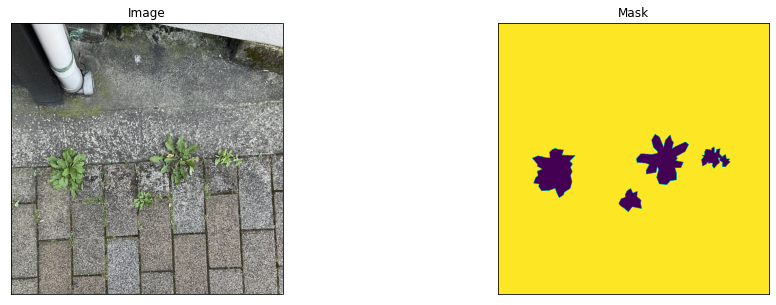

In [7]:
dataset = Dataset(os.path.join(train_dir, 'images'), os.path.join(train_dir, 'masks'), classes=['weed'])

image, mask = dataset[0]

print(image.shape)

visualzie(image=image, mask=mask.squeeze())

### Training

In [9]:
# とりあえず適当な指標を入れてみる

metrics = [smp.utils.metrics.IoU(threshold=0.5)]
loss = smp.utils.losses.DiceLoss()
optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.001),
])


In [10]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=device,
    verbose=True
)

In [11]:
max_score = 0
epoch = 40
for i in range(epoch):
    print(f'\nEpoch: {i}')
    try:
        train_logs = train_epoch.run(train_loader)
        val_logs = valid_epoch.run(valid_loader)
    except Exception as e:
        print(e)
        break
    
    if max_score < val_logs['iou_score']:
        max_score = val_logs['iou_score']
        torch.save(model, f'{decoder}_{ENCODER}.pth')
        print('Model saved!')


Epoch: 0
valid: 100%|██████████| 43/43 [00:02<00:00, 20.72it/s, dice_loss - 0.8662, iou_score - 0.08518]
Model saved!

Epoch: 1
valid: 100%|██████████| 43/43 [00:02<00:00, 20.53it/s, dice_loss - 0.6567, iou_score - 0.2517]
Model saved!

Epoch: 2
valid: 100%|██████████| 43/43 [00:02<00:00, 21.14it/s, dice_loss - 0.3439, iou_score - 0.6452]
Model saved!

Epoch: 3
valid: 100%|██████████| 43/43 [00:02<00:00, 20.65it/s, dice_loss - 0.1212, iou_score - 0.8923] 
Model saved!

Epoch: 4
valid: 100%|██████████| 43/43 [00:02<00:00, 20.53it/s, dice_loss - 0.1193, iou_score - 0.8734]

Epoch: 5
valid: 100%|██████████| 43/43 [00:02<00:00, 20.73it/s, dice_loss - 0.1139, iou_score - 0.8584]

Epoch: 6
valid: 100%|██████████| 43/43 [00:02<00:00, 21.27it/s, dice_loss - 0.0552, iou_score - 0.9423] 
Model saved!

Epoch: 7
valid: 100%|██████████| 43/43 [00:02<00:00, 21.25it/s, dice_loss - 0.06757, iou_score - 0.9272]

Epoch: 8
valid: 100%|██████████| 43/43 [00:02<00:00, 21.47it/s, dice_loss - 0.1072, iou_sc

### Check model

In [12]:
val_files = glob.glob('val/images/*')
f = val_files[5]
image_src = cv2.imread(f)
image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)

image = preprocessing_fn(image_src)
image = image.transpose(2, 0, 1).astype('float32')

image = torch.from_numpy(image).to(device).unsqueeze(0)
predict = model(image)
predict = predict.detach().cpu().numpy()[0].reshape((1024, 1024))

predict_img = np.zeros([1024, 1024]).astype(np.int8)
predict_img = np.where(predict> 0.5, 1, predict_img)

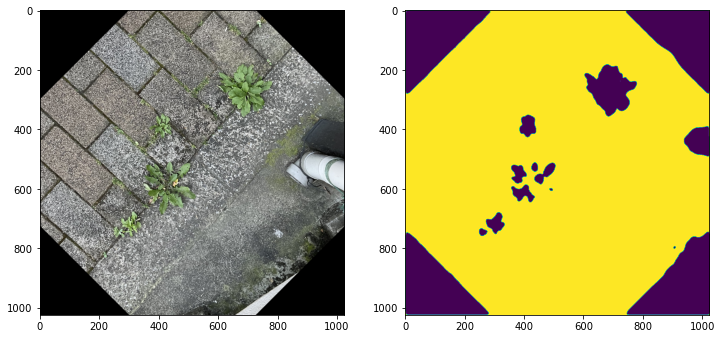

In [13]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.imshow(image_src)
ax2.imshow(predict_img)

In [14]:
# check parameters
list(model.parameters())

[Parameter containing:
 tensor([[[[ 6.6996e-03, -1.4011e-02,  4.2771e-04,  ...,  4.2391e-02,
             2.6735e-02,  2.6081e-02],
           [ 4.6284e-02,  2.5740e-02,  2.4774e-02,  ...,  2.7344e-02,
             2.5501e-02,  4.3924e-02],
           [ 9.3874e-03, -3.9363e-02, -6.6128e-02,  ..., -1.0259e-01,
            -1.1872e-01, -1.1704e-01],
           ...,
           [-1.2763e-02, -3.3707e-02, -1.3609e-02,  ...,  1.3299e-02,
             2.5101e-03,  1.8618e-02],
           [ 3.8530e-03, -2.9744e-03,  3.2956e-02,  ...,  1.0123e-01,
             7.4383e-02,  6.2001e-02],
           [ 1.8038e-02,  6.0355e-03,  3.1257e-02,  ...,  9.7282e-02,
             8.4329e-02,  1.0258e-01]],
 
          [[-1.0880e-02, -1.9504e-02,  2.8822e-03,  ...,  2.3561e-02,
             1.7849e-02,  2.1396e-02],
           [ 5.3421e-02,  3.4463e-02,  2.1974e-02,  ...,  2.6495e-03,
             9.3507e-03,  3.4892e-02],
           [-5.5614e-04, -6.7607e-02, -1.1450e-01,  ..., -2.0345e-01,
            -2.0

In [15]:
#学習曲線


In [ ]:
import cv2
import PIL
import torch
import matplotlib as plot
import segmentation_models_pytorch as smp
import albumentations
import glob
import tqdm

print(cv2.__version__)
print(PIL.__version__)
print(torch.__version__)
print(plot.__version__)
print(smp.__version__)
print(albumentations.__version__)
print(glob: 8080)
print(tqdm.__version__)
